**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
df_raw


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


In [6]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [7]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20556788143348773, 0.24904897325461184, 0.911682788913937, 0.8892311912341808, 0.8947264684857158]


In [10]:
def parallel_trees(m, fn, n_jobs=8):
    return list(ThreadPoolExecutor(n_jobs).map(fn, m.estimators_))

We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [11]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 1.81 s


(9.24679453849448, 0.22105215473435452)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [12]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 2.14 s


(9.24679453849448, 0.22105215473435452)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

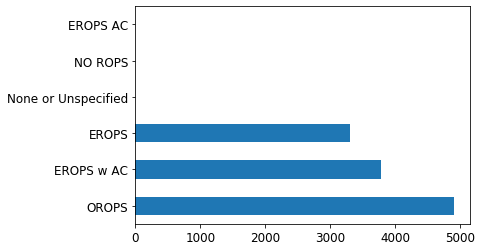

In [13]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [14]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.836087,0.272938
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.572609,0.270565
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.690616,0.222620


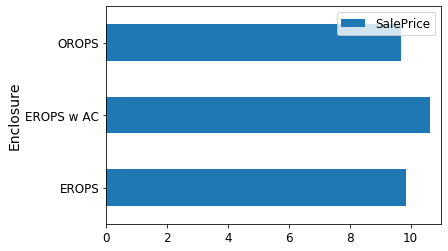

In [15]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

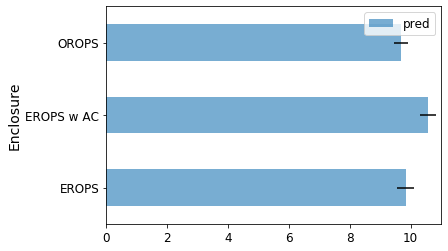

In [16]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

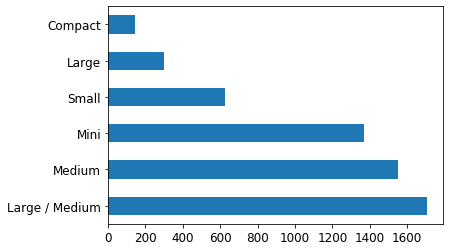

In [17]:
raw_valid.ProductSize.value_counts().plot.barh();

In [18]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.877772,0.348994
Large,10.470589,10.387976,0.349290
Large / Medium,10.691871,10.641671,0.305632
Medium,10.681511,10.627351,0.287157
Mini,9.535147,9.552026,0.248435
Small,10.324448,10.314912,0.308847


In [19]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.035331
Large             0.033624
Small             0.029942
Large / Medium    0.028720
Medium            0.027021
Mini              0.026009
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [20]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.169904
37,Coupler_System,0.096424
13,ProductSize,0.091629
14,fiProductClassDesc,0.082535
2,ModelID,0.058304
63,saleElapsed,0.051952
38,Grouser_Tracks,0.049478
39,Hydraulics_Flow,0.049292
10,fiSecondaryDesc,0.046691
19,Enclosure,0.033416


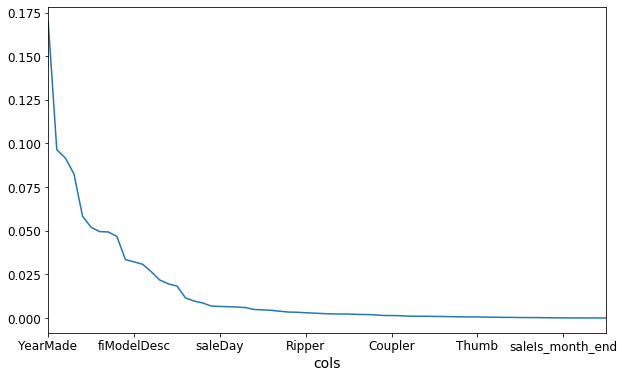

In [21]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [22]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

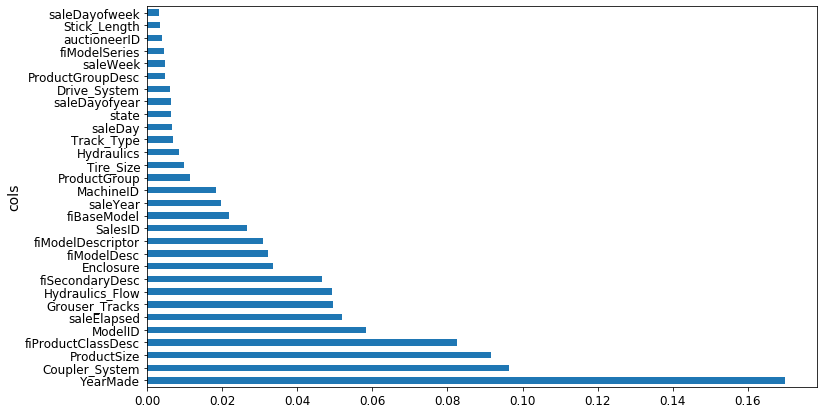

In [23]:
plot_fi(fi[:30]);

In [24]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [25]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [26]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20718041890154576, 0.24652352175264444, 0.9102917799326598, 0.8914662770437422, 0.8938814504203407]


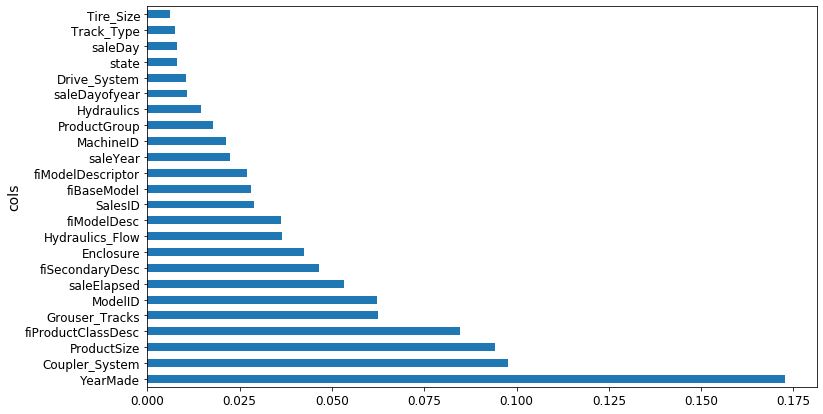

In [27]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [28]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2071530867200733, 0.25229064057011213, 0.9103154478027139, 0.8863288502248237, 0.892592711681019]


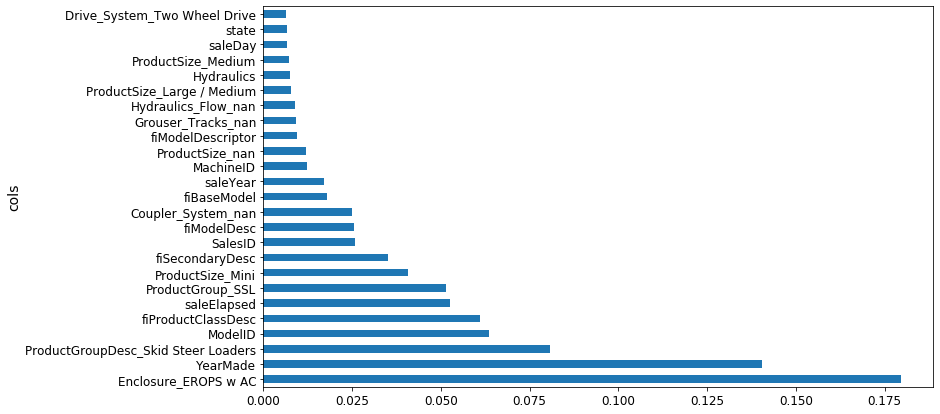

In [29]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [30]:
from scipy.cluster import hierarchy as hc

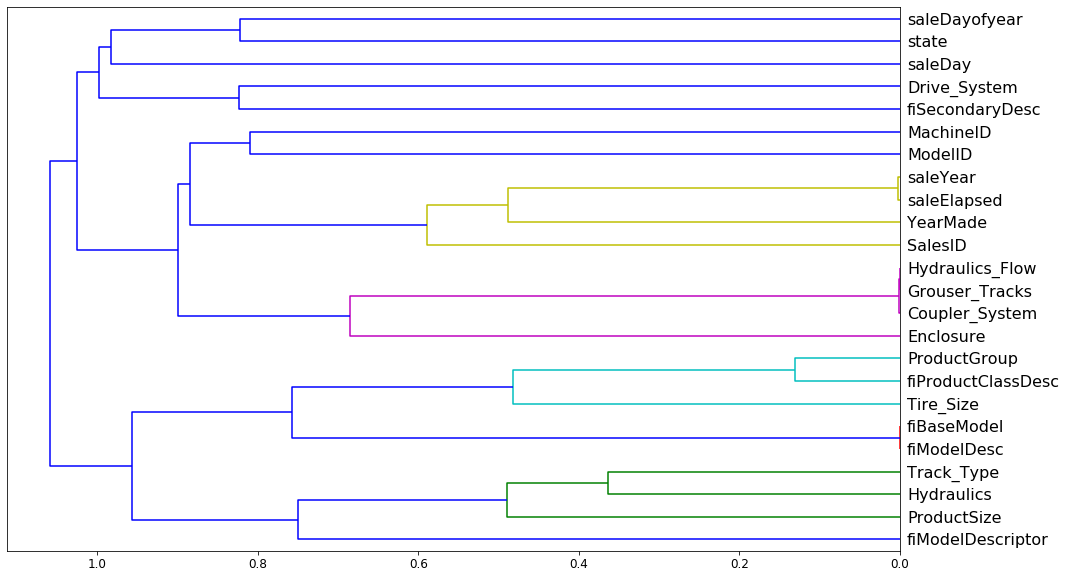

In [31]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [32]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [33]:
get_oob(df_keep)

0.8902858010080424

Now we try removing each variable one at a time.

In [34]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8893476872268606
saleElapsed 0.8875199262409337
fiModelDesc 0.8891104588889446
fiBaseModel 0.888521125669477
Grouser_Tracks 0.8902850453318967
Coupler_System 0.8902700544152975


It looks like we can try one from each group for removal. Let's see what that does.

In [35]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8886605200787433

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [36]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [37]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [38]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [39]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]
np.load = np_load_old

And let's see how this model looks on the full dataset.

In [40]:
reset_rf_samples()

In [41]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12573292016159468, 0.22671349594296358, 0.9669605483721149, 0.9082084461460744, 0.9087413047134798]


# Partial dependence

In [42]:
from pdpbox import pdp
from plotnine import *

In [43]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [44]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

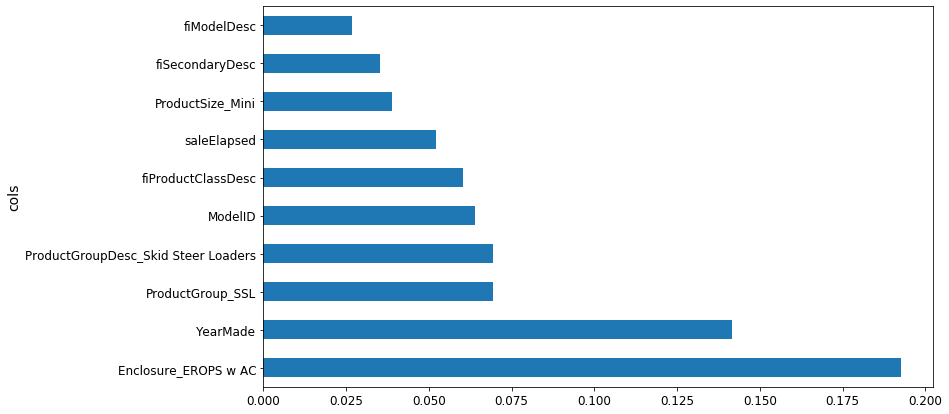

In [45]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

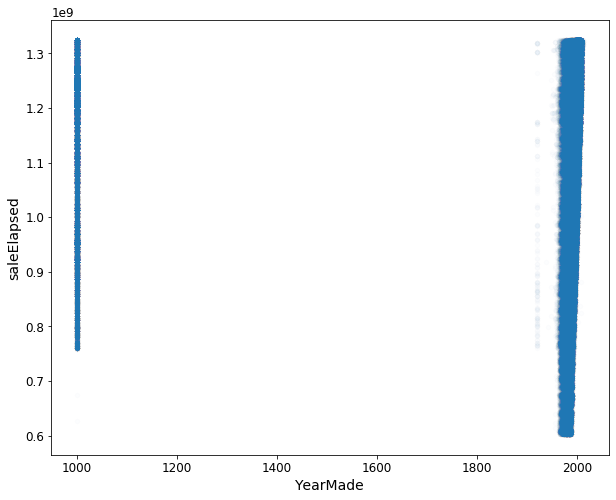

In [46]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [47]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

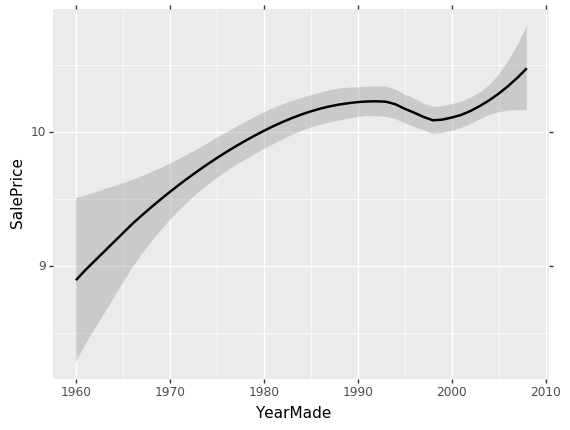

<ggplot: (-9223371905039854027)>

In [48]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [49]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [50]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

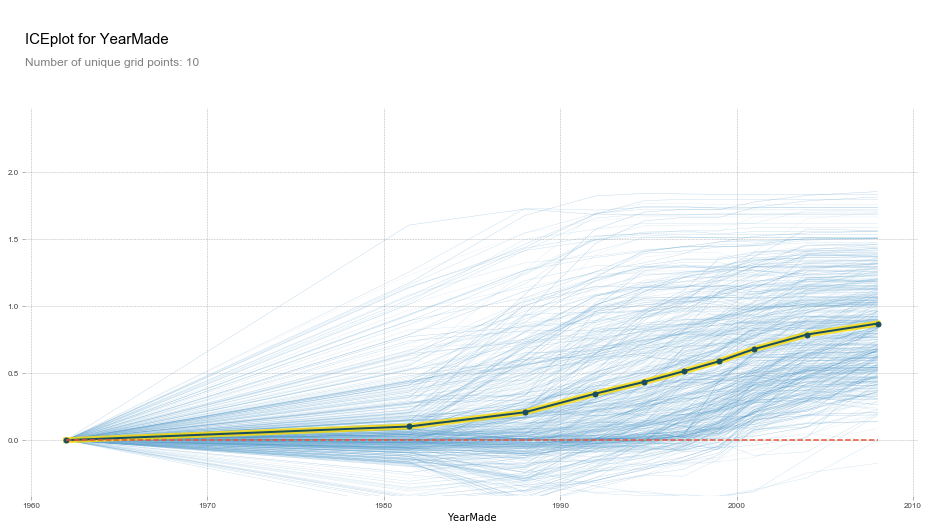

In [51]:
plot_pdp('YearMade')

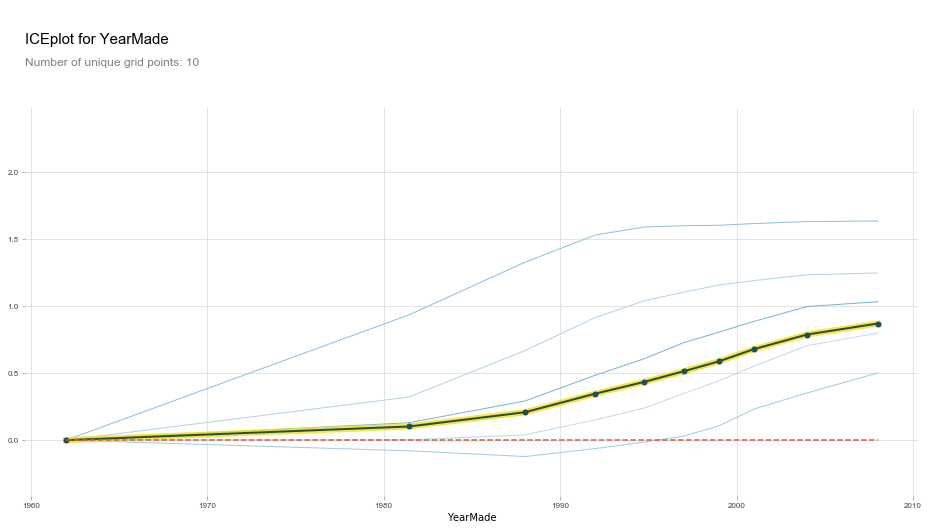

In [52]:
plot_pdp('YearMade', clusters=5)

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

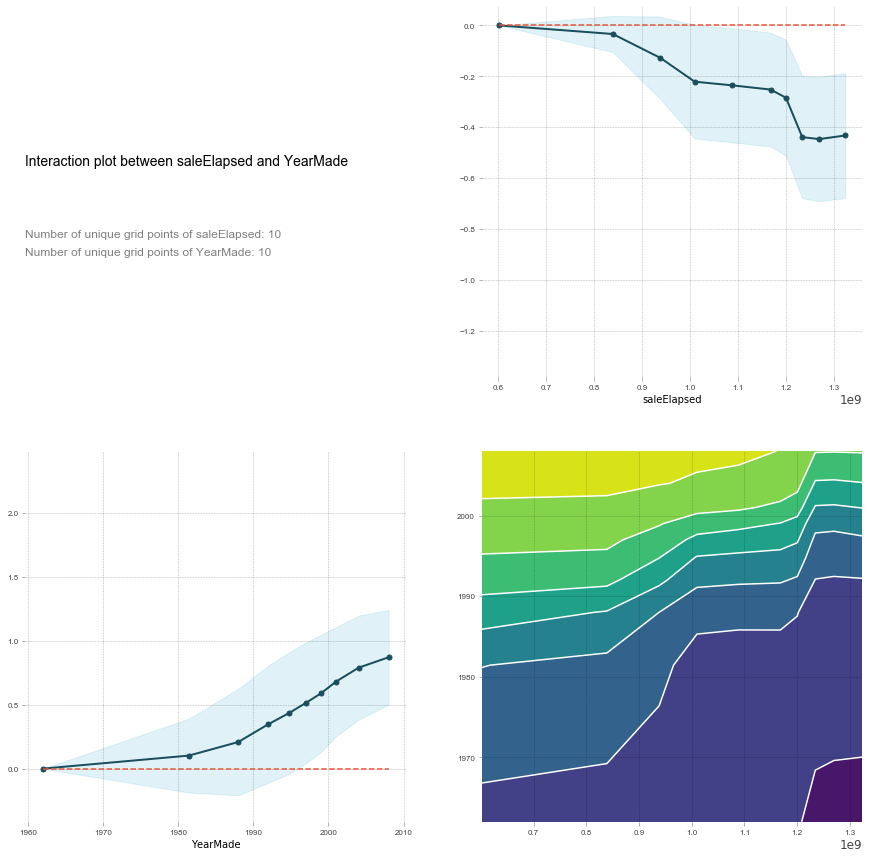

In [53]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

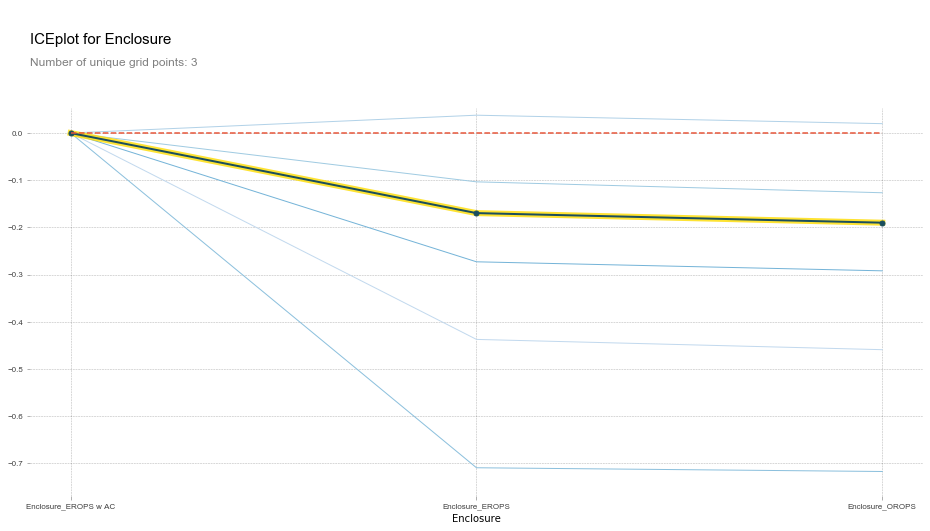

In [54]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [55]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

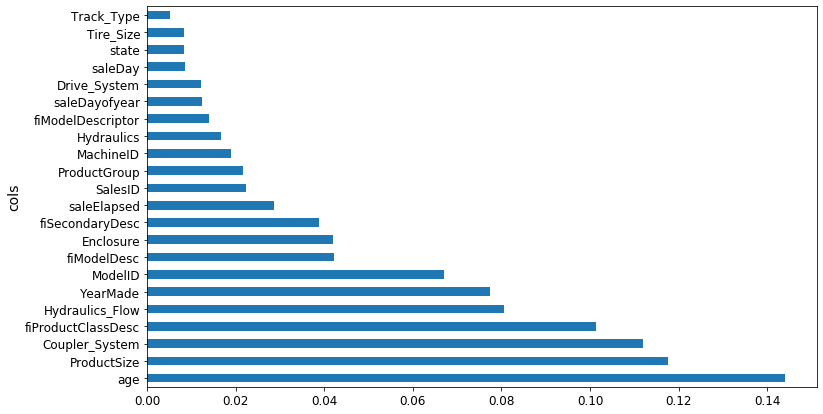

In [56]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [57]:
from treeinterpreter import treeinterpreter as ti

In [58]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [59]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          0,
                 1,       3232,          0,    4364751,    2300944,          4,          0,         12,
                 2,         16,         35,        259,          0,         11]], dtype=int64)

In [60]:
prediction, bias, contributions = ti.predict(m, row)

In [61]:
prediction[0], bias[0]

(array([9.36147]), 10.105194962378937)

In [62]:
idxs = np.argsort(contributions[0])

In [63]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5113082171740245),
 ('age', 11, -0.16033291284460488),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.10135074256119755),
 ('fiModelDesc', 'KX1212', -0.07613067241303169),
 ('fiSecondaryDesc', nan, -0.06530825335321574),
 ('Enclosure', 'EROPS', -0.026550366387089363),
 ('saleElapsed', 1284595200, -0.022694905321929415),
 ('fiModelDescriptor', nan, -0.01894567636980633),
 ('Tire_Size', nan, -0.018258076986225148),
 ('MachineID', 2300944, -0.015708576920521144),
 ('saleDayofyear', 259, -0.01288098939661908),
 ('state', 'Ohio', -0.010356083872670707),
 ('ProductGroup', 'TEX', -0.006695786035828899),
 ('SalesID', 4364751, -0.006627875155679375),
 ('saleDay', 16, -0.0009014562376776336),
 ('Drive_System', nan, 0.0003734391991780051),
 ('Hydraulics', 'Standard', 0.01931493843812202),
 ('Track_Type', 'Steel', 0.025689637819798737),
 ('Hydraulics_Flow', nan, 0.039537641311340674),
 ('Coupler_System', nan, 0.0561616526723002),
 

In [64]:
contributions[0].sum()

-0.7437264558557097

# Extrapolation

In [65]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [66]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999950140230601

In [67]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,SalesID,0.862071
5,saleElapsed,0.089344
12,MachineID,0.040599
19,saleDayofyear,0.003833
0,YearMade,0.001466
4,ModelID,0.000905
9,fiModelDesc,0.000521
15,Hydraulics,0.000502
1,Coupler_System,0.000193
6,Hydraulics_Flow,0.000146


In [68]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [69]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [70]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [71]:
x.drop(feats, axis=1, inplace=True)

In [72]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9788594577750078

In [73]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.230029
0,YearMade,0.184514
16,saleDayofyear,0.161426
4,ModelID,0.077471
8,fiModelDesc,0.063409
14,saleDay,0.059089
15,state,0.055268
3,fiProductClassDesc,0.032873
6,fiSecondaryDesc,0.024598
7,Enclosure,0.021903


In [74]:
set_rf_samples(50000)

In [75]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [76]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2079687662858074, 0.24784653260723413, 0.9096077790739717, 0.8902982213854745, 0.8929815914512201]


In [77]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20902027843834425, 0.24400760229513574, 0.9086914029450054, 0.893670275450794, 0.8925177209844697]
saleElapsed
[0.2144489353388475, 0.25416440197337214, 0.9038868933712337, 0.8846341099031159, 0.8868218884489095]
MachineID
[0.2067249128829469, 0.24534186374219955, 0.9106858105477633, 0.8925042499990773, 0.8950624088162704]
age
[0.2094639437400888, 0.2474806381602494, 0.9083033693034476, 0.8906218865383142, 0.8917003815412536]
YearMade
[0.2085351011583751, 0.25063286019131675, 0.9091148014934693, 0.8878177892022511, 0.8926701960892116]
saleDayofyear
[0.20882810901436202, 0.24526263643202167, 0.9088592206760375, 0.892573665172516, 0.8928123085349788]


In [78]:
reset_rf_samples()

In [79]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13842434228520764, 0.21889207737035926, 0.9599539427939277, 0.9144326544168495, 0.9091463473028796]


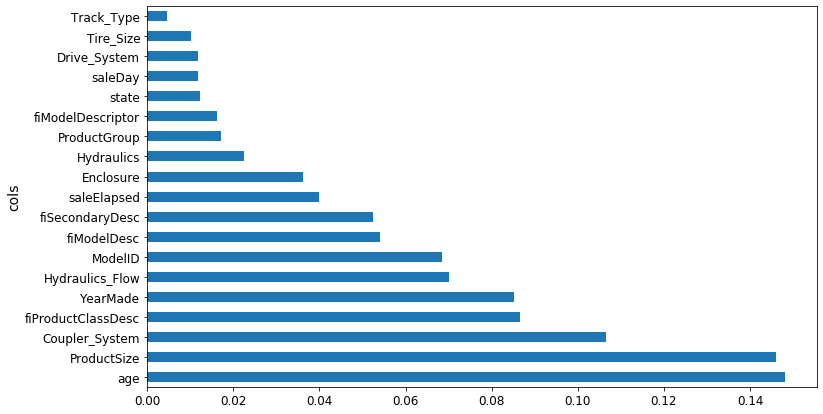

In [80]:
plot_fi(rf_feat_importance(m, X_train));

In [81]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [82]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1min 3s
[0.08007687120845185, 0.21108049454218797, 0.9865986355532727, 0.9204309486971953, 0.9146579826671648]
